EJERCICIO DE OPTIMIZACIÓN DE LAS GANANCIAS DEL CONTROLADOR PID.

Sobre el controlador PID desarrollado en la práctica anterior, desarrollar un algoritmo genético que sea capaz de optimizar el valor de las ganancias Kp, Ki y Kd, a fin de obtener el controlador con mejor rendimiento posible.
Para ello, se debe:
- Definir el tamaño del cromosoma
- Definir la función de fitness
- La selección se realizará por torneo. Definir el valor de T
- Especificar el número de itaraciones para ajustar el controlador
- Definir el tamaño de la población


MODELO, CONTROLADOR PID E ÍNDICES DE RENDIMIENTO

In [1]:
class DC_motor_sim:
    def __init__(self):
        self.R = 1.11  # Ohm
        self.L = 0.0002  # H
        self.J = 6.77E-6  # Kgm²
        self.fv = 1.66E-5  # Nm/(Rad/s)
        self.K = 0.0364  # Nm/A or V/(Rad/s)
        self.ea = 0.0
        self.w = [0.0, 0.0]  # tk angular speed
        self.i = [0.0, 0.0]  # tk current

    def init(self):
        self.R = 1.11
        self.L = 0.0002
        self.J = 6.77E-6
        self.fv = 1.66E-5
        self.K = 0.0364
        self.ea = 0.0
        self.w = [0.0, 0.0]
        self.i = [0.0, 0.0]

    def Set_ea(self, new_ea):
        self.ea = new_ea
        # Saturation effect due to battery limits
        if self.ea > 24.0:
            self.ea = 24.0
        if self.ea < -24.0:
            self.ea = -24.


    def Give_me_speed(self): 
        return self.w[0]

    def Exec_cycle(self):
        # Motor behavior considering T = 0.0001s
        self.w[0] = self.w[1]
        self.i[0] = self.i[1]
        self.w[1] = 0.999755 * self.w[0] + 14.769238 * self.K * self.i[0]
        self.i[1] = 0.574072 * self.i[0] + 0.383719 * (self.ea - self.K * self.w[1])
        
class Controller:
    def __init__(self):
        self.Kp = 0.0
        self.Ki = 0.0
        self.Kd = 0.0
        self.Angular_speed_reference = 0.0
        self.Noise_Filtering_N = 8
        self.Controller_T = 0.001
        self.motor_sim = DC_motor_sim()
        self.motor_speed_anterior = 0
        self.I_anterior = 0
        self.D_anterior = 0

    def Init(self, new_Kp, new_Ki, new_Kd):
        self.Kp = new_Kp
        self.Ki = new_Ki
        self.Kd = new_Kd

        # Inicializar el motor
        self.motor_sim.init()
        

    def Set_reference(self, Angular_speed):
        self.Angular_speed_reference = Angular_speed

    def Exec_controller_cycle(self):
        # Compute control parameters
        motor_speed = DC_motor_sim.Give_me_speed(self.motor_sim)
        error = self.Angular_speed_reference - motor_speed
        
        P = error * self.Kp
        I = self.I_anterior + self.Kp * self.Controller_T / self.Ki * error if self.Ki !=  0 else 0
        D = self.Kd / (self.Kd + self.Noise_Filtering_N * self.Controller_T) * self.D_anterior - self.Kp * self.Kd * self.Noise_Filtering_N / (self.Kd + self.Noise_Filtering_N * self.Controller_T) * (motor_speed - self.motor_speed_anterior) if self.Kd != 0 else 0
        
        # Prepare last error for next cycle       
        self.motor_speed_anterior = motor_speed

        # Prepare last I and D values for next cycle
        self.I_anterior = I
        self.D_anterior = D
        
        # Compute controller output
        new_motor_voltage = P+I+D
        DC_motor_sim.Set_ea(self.motor_sim, new_motor_voltage)
        DC_motor_sim.Exec_cycle(self.motor_sim)

        return motor_speed, new_motor_voltage
    
    
import numpy as np
import statistics as stat

class Performance:    
    def __init__(self):
        self.Overshoot = 0.0
        self.d = 0.0
        self.Ess = 0.0
        self.Ts = 0.0
        self.v = []
        self.VR = 0.0

    def Init(self, velocidades, Velocidad_de_referencia):
        self.Overshoot = 0.0
        self.d = 0.0
        self.Ess = 0.0
        self.Ts = 0.0
        self.v = velocidades
        self.VR = Velocidad_de_referencia
        
    def Calcula_indexes(self):
   
        # Get number of samples
        num_samples = len(self.v)

        # Sample index where signal is considered stable (last 30% of points are considered stable)
        n_stable = round(num_samples * 0.30) 
        settle_value = sum(self.v[-n_stable:]) / n_stable

        # Iterate over curve and get all max points
        rising = True if self.v[0] < self.v[1] else False
        max_count = 0 # max point counter
        max_values = [] # list to save all max values
        first_overshoot = 0
        second_overshoot = 0
        for i, point in enumerate(self.v):
            if i == 0: continue # skip the first (will always compare each point with the previous one)
            elif rising:
                if point < self.v[i-1]: # not rising anymore
                    rising = False
                    max_count += 1
                    max_values.append({'x': i-1, 'y': self.v[i-1]}) # save local maxima

                    # Save first or second overshoot
                    if first_overshoot == 0:
                        if self.v[i-1] > settle_value:
                            first_overshoot = self.v[i-1]
                    elif second_overshoot == 0:
                        second_overshoot = self.v[i-1]
                    elif self.v[i-1] > first_overshoot: # In case response is not stable
                        second_overshoot = self.v[i-1]     
                        
            else: # If decreasing
                if point > self.v[i-1]: # rising again
                    rising = True
        
        # Calculate overshoot
        if first_overshoot > 0:
            self.Overshoot = first_overshoot / settle_value - 1

        # Calculate second overshoot
        if second_overshoot > settle_value:
            second_overshoot = second_overshoot / settle_value - 1
        else:
            second_overshoot = 0

        # Calculate decay ratio
        if abs(first_overshoot) > 0:
            self.d = abs(second_overshoot / self.Overshoot)

        # Calculate Steady State Error
        self.Ess = abs(settle_value - self.VR)
        # self.Ess = abs(self.Ess / settle_value) * 100.0

        # Calculate settling time (1% of steady state value)
        settle_point = -1
        for i, point_i in enumerate(self.v): 
            settle_time_found_flag = True # Flag used to know if for loop reached end or was interrupted
            for j, point_j in enumerate(self.v[i:]): 
                if abs( (point_j - settle_value) / settle_value ) > 0.01:
                    settle_time_found_flag = False # Settle point not reached yet
                    break
            if settle_time_found_flag:
                settle_point = i # Settle point was found
                break

        self.Ts = settle_point

        if(settle_point == -1):
            # print("WARNING: System doesn't reach steady state.")
            self.Ts = len(self.v)

        return self.Overshoot, self.d, self.Ess, self.Ts


ALGORITMO GENÉTICO

In [2]:
import random
from operator import itemgetter
from statistics import mean

#algoritmo genético
class Genetico:

    def __init__(self, w_ts = 25., w_d = .6, w_overshoot = 200., w_ess = 15.):
        #Fitness
        self.Fitness = 0
        self.w = (w_ts, w_d, w_overshoot, w_ess) # weight of ts, d, overshoot, ess  (25., .6, 200., 15.)
        self.fitness_curve_mean = []
        self.fitness_curve_best = []
        
    def llamada_control(self, Gen_Kp, Gen_Ki, Gen_Kd):   
        # Crear una instancia del controlador
        controller = Controller()
        Kp=Gen_Kp
        Ki=Gen_Ki
        Kd=Gen_Kd
        velocidad=[]
        ut=[]
        coordenadax=[]
        Velocidad_de_referencia = 50.0
        overshoot = 0.0
        d=0.0
        Ess=0.0
        Ts = 0.0
        
        # Inicializar el controlador con los valores de ganancia
        controller.Init(Kp, Ki, Kd)
        
        # Establecer la velocidad de referencia
        controller.Set_reference(Velocidad_de_referencia)

        # Ejecutar 320 ciclos del controlador
        for ite in range(320):
            x,y = controller.Exec_controller_cycle()
            velocidad.append(x)
            
        #Cálculo de los índices de rendimiento
        P = Performance() 
        P.Init(velocidad, Velocidad_de_referencia)
        overshoot, d, Ess, Ts = P.Calcula_indexes()
        
        Fitness = self.w[0] * Ts + self.w[1] * d + self.w[2] * overshoot + self.w[3] * Ess
        
        return Fitness
    
    # Función de evaluación (fitness)
    def evaluate(self, chromosome):
        # Aquí debes implementar la evaluación del cromosoma y retornar un valor de fitness
        fitness = self.llamada_control(chromosome[0], chromosome[1], chromosome[2])
        return fitness

    # Generar un cromosoma aleatorio
    def generate_random_chromosome(self, length):  
        chromosome = []
        for _ in range(length):
            gene = random.uniform(0.0, 10.0)  # Generar número aleatorio en el rango [0.0, 10.0]
            chromosome.append(gene)            
        return chromosome

    # Cruzar dos cromosomas
    def crossover(self, chromosome1, chromosome2, crossover_rate):
        new_chromosome=chromosome1
        if random.random() < crossover_rate:
            crossover_point = random.randint(1, len(chromosome1) - 1)
            new_chromosome = chromosome1[:crossover_point] + chromosome2[crossover_point:]
        return new_chromosome
        
    # Mutar un cromosoma
    def mutate(self, chromosome, mutation_rate):
        mutated_chromosome = []
        for gene in chromosome:
            if random.random() < mutation_rate:
                mutated_gene = random.uniform(0.0, 10.0)  # Generar número aleatorio en el rango [0.0, 5.0]
            else:
                mutated_gene = gene
            mutated_chromosome.append(mutated_gene)
        return mutated_chromosome

    #selección por torneo
    def selection_tournament(self, population_size, evaluated_population, T):
            parents = []            
            while len(parents) < population_size:
                candidates=[]
                for ite in range(T):
                    candidates.append(random.choice(evaluated_population))                            
                parents.append(min(candidates, key=itemgetter(1))[0])
            return parents
    
    # Algoritmo genético
    def genetic_algorithm(self, population_size, chromosome_length, generations, mutation_rate, crossover_rate, T=8):
        population = []
        for _ in range(population_size):
            chromosome = self.generate_random_chromosome(chromosome_length)
            population.append(chromosome)
       
        for generation in range(generations):            
            # Evaluación de la población
            evaluated_population = [(chromosome, self.evaluate(chromosome)) for chromosome in population]

            # Selección de padres mediante torneo de longitud T
            parents = []
            # T=8 # Se seleccionan 8 cromosomas de manera aleatoria pra el torneo. Nos quedaremos con el de menor función de fitness
            parents = self.selection_tournament(population_size, evaluated_population, T)

            # Cruzamiento y mutación para generar descendencia
            offspring = []
            for i in range(0, population_size, 2):
                parent1 = parents[i]
                parent2 = parents[i + 1]
                child1 = self.crossover(parent1, parent2, crossover_rate)
                child2 = self.crossover(parent2, parent1, crossover_rate)
                mutated_child1 = self.mutate(child1, mutation_rate)
                mutated_child2 = self.mutate(child2, mutation_rate)
                offspring.extend([mutated_child1, mutated_child2])

            # Reemplazar la población anterior con la descendencia
            population = offspring

            self.fitness_curve_best.append(min(evaluated_population, key=lambda x: x[1])[1]) # Best chromosome only
            self.fitness_curve_mean.append(sum([x[1] for x in evaluated_population])/len(evaluated_population))# Average chromosome

        # Devolver el mejor cromosoma de la última generación
        best_chromosome = min(evaluated_population, key=lambda x: x[1])#[0]
        return best_chromosome, self.fitness_curve_best, self.fitness_curve_mean



Dibujar el resultado de la optimización mediante el algoritmo genético

In [3]:
from matplotlib import pyplot as plt

class dibujacontrol:
    

    def dibujar (self, Kp, Ki, Kd, fitness_curve_best, fitness_curve_mean):
        
        # fig, ax = plt.subplots()
        # fig, ax2 = plt.subplots()
        # fig, ax3 = plt.subplots()

        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(11, 7),
                        layout="constrained")
        
        ax1 = axs[0,0]
        ax2 = axs[0,1]
        ax3 = axs[1,0]
        ax4 = axs[1,1]
        
        P = Performance()  
        
        # Crear una instancia del controlador
        controller = Controller()

        
        velocidad=[]
        ut=[]
        coordenadax=[]

        Velocidad_de_referencia = 50.0
        
        # Inicializar el controlador con los valores de ganancia
        controller.Init(Kp, Ki, Kd)

        # Establecer la velocidad de referencia
        controller.Set_reference(Velocidad_de_referencia)

        # Ejecutar 320 ciclos del controlador
        for ite in range(320):
            x,y = controller.Exec_controller_cycle()
            velocidad.append(x)
            ut.append(y)
            coordenadax.append(ite)

        

        ax1.plot(range(len(fitness_curve_best)), fitness_curve_best, linewidth=2.0)
        ax1.grid(axis='x', color='0.95')
        ax1.grid(axis='y', color='0.95')
        ax1.set_title('Fitness Curve (best chromosome)')

        ax2.plot(range(len(fitness_curve_mean)), fitness_curve_mean, linewidth=2.0)
        ax2.grid(axis='x', color='0.95')
        ax2.grid(axis='y', color='0.95')
        ax2.set_title('Fitness Curve (mean)')

        ax3.plot(coordenadax, velocidad, linewidth=2.0)
        ax3.grid(axis='x', color='0.95')
        ax3.grid(axis='y', color='0.95')
        ax3.set_title('System Response')

        ax4.plot(coordenadax, ut, linewidth=2.0)
        ax4.grid(axis='x', color='0.95')
        ax4.grid(axis='y', color='0.95')
        ax4.set_title('Controller Action')

        P.Init(velocidad, Velocidad_de_referencia)
        o, d, Ess, Ts = P.Calcula_indexes()
        print("Overshoot: ",o)
        print("d: ",d)
        print("Ess: ",Ess)
        print("Ts:", Ts)

Llamada al algoritmo genético (tarda un poquito, en función de el número de generaciones programadas)

Mejor cromosoma: ([0.3666375241080255, 0.06723088109100495, 0.001331845544104704], 260.37991320931064)
Overshoot:  0.008394762381107146
d:  0.058088075890391964
Ess:  0.0008107806747759128
Ts: 13


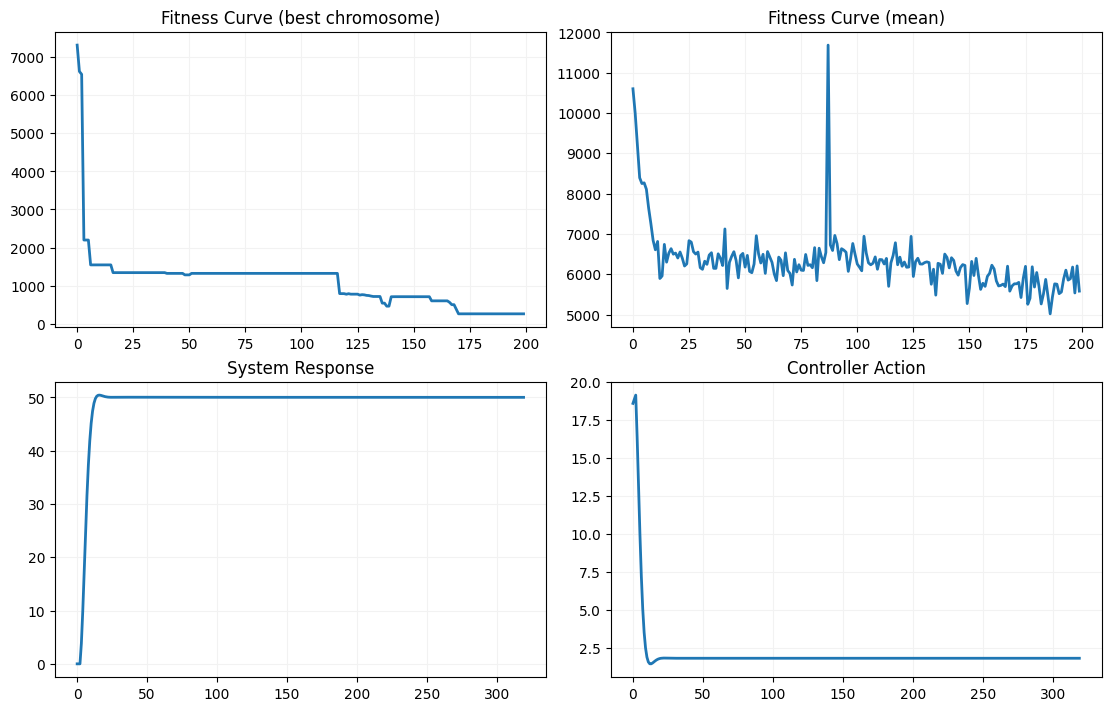

In [13]:
# Parámetros del algoritmo genético
population_size = 200 # 100
chromosome_length = 3
generations = 200 # 200
mutation_rate = 0.4 # 0.1
crossover_rate = 0.7 # 0.6
T = 8 # 8

gen = Genetico(w_ts=20., w_d=5., w_overshoot=1., w_ess=100.)

# Ejecutar el algoritmo genético
best_chromosome, fitness_curve_best, fitness_curve_mean = gen.genetic_algorithm(population_size, chromosome_length, generations, mutation_rate, crossover_rate, T)

# Imprimir el resultado
print("Mejor cromosoma:", best_chromosome)
BC = best_chromosome[0]
DC = dibujacontrol()
DC.dibujar(BC[0], BC[1], BC[2], fitness_curve_best, fitness_curve_mean)